In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
def option_chains(ticker):
    asset = yf.Ticker(ticker)
    expirations = asset.options
    chains = pd.DataFrame()

    for expiration in expirations:
        option = asset.option_chain(expiration)
        
        calls = option.calls
        calls['optionType'] = "call"
        
        puts = option.puts
        puts['optionType'] = "put"
        
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        chains = pd.concat([chains, chain])
    
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    
    return chains

In [9]:
aapl = option_chains("AAPL")
aapl_calls = aapl[aapl["optionType"] == "call"]

aapl_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration
0,AAPL231124C00050000,2023-11-22 16:20:34+00:00,50.0,141.35,141.10,141.50,0.00,0.000000,12.0,6,7.820313,True,REGULAR,USD,call,2023-11-24 23:59:59,2
1,AAPL231124C00075000,2023-11-03 18:07:22+00:00,75.0,100.21,116.10,116.50,0.00,0.000000,1.0,0,5.554691,True,REGULAR,USD,call,2023-11-24 23:59:59,2
2,AAPL231124C00090000,2023-11-01 14:00:00+00:00,90.0,81.35,101.10,101.50,0.00,0.000000,1.0,0,4.546879,True,REGULAR,USD,call,2023-11-24 23:59:59,2
3,AAPL231124C00095000,2023-10-25 14:10:07+00:00,95.0,77.10,96.10,96.50,0.00,0.000000,NaN,0,4.246098,True,REGULAR,USD,call,2023-11-24 23:59:59,2
4,AAPL231124C00100000,2023-11-10 19:30:52+00:00,100.0,85.83,91.10,91.50,0.00,0.000000,7.0,7,3.960938,True,REGULAR,USD,call,2023-11-24 23:59:59,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,AAPL260116C00280000,2023-11-22 14:33:28+00:00,280.0,6.45,6.15,6.45,0.33,5.392156,2.0,67,0.249229,False,REGULAR,USD,call,2026-01-16 23:59:59,786
47,AAPL260116C00285000,2023-11-22 17:23:17+00:00,285.0,5.60,5.50,5.75,0.15,2.752295,4.0,51,0.246925,False,REGULAR,USD,call,2026-01-16 23:59:59,786
48,AAPL260116C00290000,2023-11-22 18:34:59+00:00,290.0,5.06,4.90,5.10,0.24,4.979248,1.0,96,0.244484,False,REGULAR,USD,call,2026-01-16 23:59:59,786
49,AAPL260116C00300000,2023-11-22 20:47:25+00:00,300.0,4.10,3.95,4.20,0.20,5.128200,19.0,4950,0.243385,False,REGULAR,USD,call,2026-01-16 23:59:59,786


<AxesSubplot: title={'center': 'Implied Volatility Skew'}, xlabel='strike'>

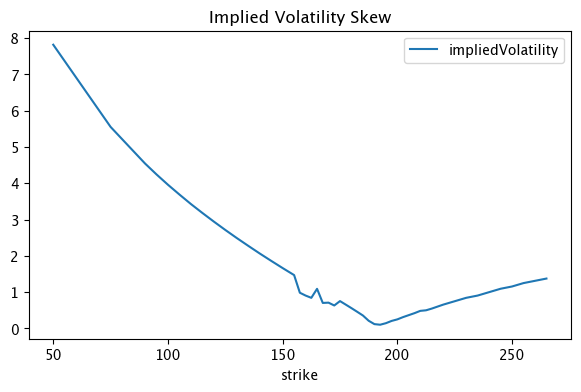

In [8]:
calls_at_expiry = aapl_calls[aapl_calls["expiration"] == "2023-11-24 23:59:59"]
# filter out low vols
filtered_calls_at_expiry = calls_at_expiry[calls_at_expiry.impliedVolatility >= 0.001]
filtered_calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(title="Implied Volatility Skew", figsize=(7, 4))

<AxesSubplot: title={'center': 'Implied Volatility Term Structure'}, xlabel='expiration'>

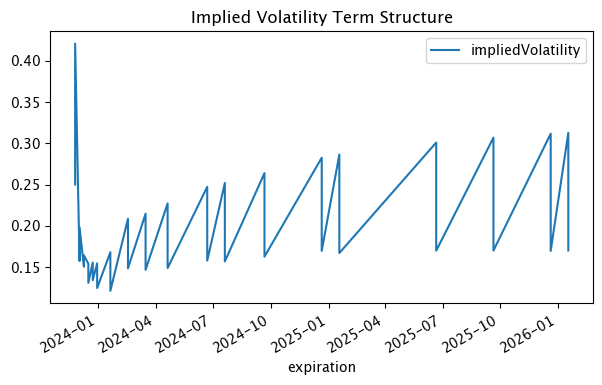

In [10]:
calls_at_strike = aapl[aapl["strike"] == 200.0]
# filter out low vols
filtered_calls_at_strike = calls_at_strike[calls_at_strike.impliedVolatility >= 0.001]
filtered_calls_at_strike[["expiration", "impliedVolatility"]].set_index("expiration").plot(title="Implied Volatility Term Structure", figsize=(7, 4))

In [15]:
def plot_implied_vol_surface(ticker):
    option = option_chains(ticker)
    calls = option[option["optionType"] == "call"]
    surface = (calls[['daysToExpiration', 'strike', 'impliedVolatility']].pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration').dropna())

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = surface.columns.values, surface.index.values, surface.values
    X, Y = np.meshgrid(x, y)
    ax.set_xlabel('Days to expiration')
    ax.set_ylabel('Strike price')
    ax.set_zlabel('Implied volatility')
    ax.set_title('Call implied volatility surface')
    ax.plot_surface(X, Y, z)

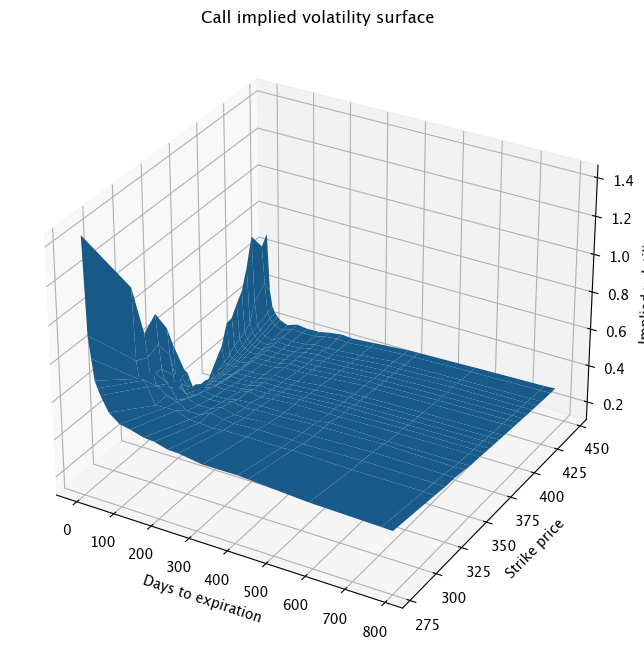

In [19]:
plot_implied_vol_surface('MSFT')